<a href="https://colab.research.google.com/github/gabitza-tech/Machine-Learning-Collection/blob/master/GMM_adult_income.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from pandas import DataFrame 
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture 
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

In [5]:
raw_df = pd.read_csv('/content/adult.csv')
raw_df = raw_df.drop('income', axis = 1) 
features_string=["workclass",  "education",  "marital-status", "occupation", "relationship", "race", "gender", "native-country"]

raw_df = raw_df.replace('?', np.NaN)
raw_df.fillna(method ='ffill', inplace = True) 

print(raw_df)

       age         workclass  fnlwgt     education  educational-num  \
0       25           Private  226802          11th                7   
1       38           Private   89814       HS-grad                9   
2       28         Local-gov  336951    Assoc-acdm               12   
3       44           Private  160323  Some-college               10   
4       18           Private  103497  Some-college               10   
...    ...               ...     ...           ...              ...   
38459   42           Private  341757  Some-college               10   
38460   36           Private  218542       HS-grad                9   
38461   44         Local-gov  190020     Bachelors               13   
38462   27           Private  221436     Bachelors               13   
38463   39  Self-emp-not-inc   52187       HS-grad                9   

           marital-status         occupation   relationship   race  gender  \
0           Never-married  Machine-op-inspct      Own-child  Black   

In [6]:
labelEncoder = LabelEncoder()
for feature in features_string:
  print(feature)
  labelEncoder.fit(raw_df[feature])
  raw_df[feature] = labelEncoder.transform(raw_df[feature])

print(raw_df)

workclass
education
marital-status
occupation
relationship
race
gender
native-country
       age  workclass  fnlwgt  education  educational-num  marital-status  \
0       25          3  226802          1                7               4   
1       38          3   89814         11                9               2   
2       28          1  336951          7               12               2   
3       44          3  160323         15               10               2   
4       18          3  103497         15               10               4   
...    ...        ...     ...        ...              ...             ...   
38459   42          3  341757         15               10               4   
38460   36          3  218542         11                9               5   
38461   44          1  190020          9               13               2   
38462   27          3  221436          9               13               2   
38463   39          5   52187         11                9          

In [7]:
# Standardize data
scaler = StandardScaler() 
scaled_df = scaler.fit_transform(raw_df) 
  
# Normalizing the Data 
normalized_df = normalize(scaled_df) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df) 
  
# Reducing the dimensions of the data 
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(normalized_df) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 
  
X_principal.head(2)

,P1,P2
0,0.391866,-0.084570
1,-0.656572,-0.206337


In [8]:
gmm = GaussianMixture(n_components = 2) 
gmm.fit(X_principal)

GaussianMixture(n_components=2)

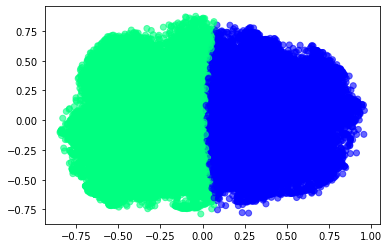

In [9]:
# Visualizing the clustering 
plt.scatter(X_principal['P1'], X_principal['P2'],  
           c = GaussianMixture(n_components = 2).fit_predict(X_principal), cmap =plt.cm.winter, alpha = 0.6) 
plt.show() 

In [10]:
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [11]:
n_clusters=np.arange(2, 8)
sils=[]
sils_err=[]
iterations=20
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gmm=GaussianMixture(n, n_init=2).fit(X_principal) 
        labels=gmm.predict(X_principal)
        sil=metrics.silhouette_score(X_principal, labels, metric='euclidean')
        tmp_sil.append(sil)
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)

Text(0, 0.5, 'Score')

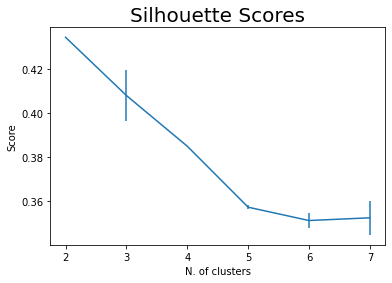

In [12]:
plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

In [13]:
#Courtesy of https://stackoverflow.com/questions/26079881/kl-divergence-of-two-gmms. Here the difference is that we take the squared root, so it's a proper metric

def gmm_js(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)

In [14]:
n_clusters=np.arange(2, 8)
iterations=20
results=[]
res_sigs=[]
for n in n_clusters:
    dist=[]
    
    for iteration in range(iterations):
        train, test=train_test_split(X_principal, test_size=0.5)
        
        gmm_train=GaussianMixture(n, n_init=2).fit(train) 
        gmm_test=GaussianMixture(n, n_init=2).fit(test) 
        dist.append(gmm_js(gmm_train, gmm_test))
    selec=SelBest(np.array(dist), int(iterations/5))
    result=np.mean(selec)
    res_sig=np.std(selec)
    results.append(result)
    res_sigs.append(res_sig)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but G

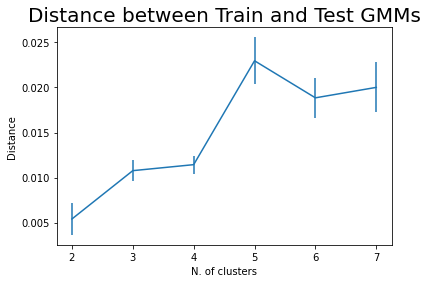

In [15]:
plt.errorbar(n_clusters, results, yerr=res_sigs)
plt.title("Distance between Train and Test GMMs", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Distance")
plt.show()

In [16]:
n_clusters=np.arange(2, 8)
bics=[]
bics_err=[]
iterations=20
for n in n_clusters:
    tmp_bic=[]
    for _ in range(iterations):
        gmm=GaussianMixture(n, n_init=2).fit(X_principal) 
        
        tmp_bic.append(gmm.bic(X_principal))
    val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
    err=np.std(tmp_bic)
    bics.append(val)
    bics_err.append(err)

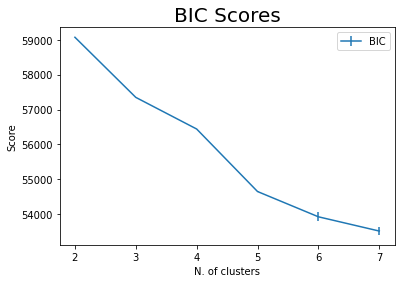

In [17]:
plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.legend()